In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import gym

import imitation_learning

In [2]:
num_steps     = 50
batch_size    = 4
n_iterations  = 10000


input_size    = 16
action_size   = 4
num_units     = 5
learning_rate = 0.01

In [3]:
def preprocess_state(s):
    S = np.zeros((1,input_size), np.float32)
    S[0,s] = 1
    return S   

In [4]:
policy = keras.Sequential([
            keras.layers.Input(shape=[input_size]),
            keras.layers.Dense(action_size, activation=tf.nn.softmax)
        ])

value_function = keras.Sequential([
            keras.layers.Input(shape=[input_size]),
            keras.layers.Dense(1, activation=tf.identity)
        ])

In [5]:
agent = imitation_learning.model.DiscreteActorCritic(
    policy, value_function, preprocess_state, learning_rate
)

In [6]:
env = gym.make('FrozenLake-v0').env.__class__(
    map_name='4x4', is_slippery=False)
# from imitation_learning.test import TestEnv
# env = TestEnv(right=20)

In [7]:
sim   = imitation_learning.simulator.Simulator(env, agent)

In [16]:
count = 0
avg_r = 0
rewards = []
for it in range(n_iterations):
    
    r = sim.run(render=False, num_steps=num_steps)
    
    avg_r = 0.9*avg_r + 0.1*r
    rewards.append(avg_r)
    T = sim.tuples

    S = np.zeros((1, num_steps, input_size), np.float32)
    A = np.zeros((1, num_steps, action_size), np.float32)
    R = np.zeros((1, num_steps,1), np.float32)
    I = np.zeros((1, num_steps,1), np.float32)
    
    n = len(T)
    
    for k,t in enumerate(T):
        S[0,k,t[0]] = 1
        A[0,k,t[1]] = 1
        I[0,k,0]    = 1
    
    R[0,:n,0] = np.cumsum([t[2] for t in T])[::-1]
    
    loss = agent.train(S, A, R, I)
        
    if it%500 == 0:
        print("{} r={} loss={:.2f}".format(it,r,loss))
        print(0,list(policy.predict(preprocess_state(0))[0]))

0 r=0.0 loss=0.00
0 [0.0671017, 0.53179955, 0.10233013, 0.29876864]
500 r=0.0 loss=0.00
0 [0.06241332, 0.4273646, 0.09092317, 0.4192989]
1000 r=0.0 loss=-0.05
0 [0.058937106, 0.38705614, 0.08520388, 0.46880284]
1500 r=0.0 loss=0.00
0 [0.07309435, 0.37787315, 0.08628269, 0.4627497]
2000 r=0.0 loss=0.00
0 [0.06555141, 0.30731222, 0.07622978, 0.55090666]
2500 r=0.0 loss=0.00
0 [0.06205094, 0.44264758, 0.07281275, 0.42248875]
3000 r=0.0 loss=0.00
0 [0.054490354, 0.53104573, 0.06321486, 0.35124904]
3500 r=0.0 loss=-0.03
0 [0.05290067, 0.47904736, 0.061235547, 0.40681636]
4000 r=0.0 loss=-0.03
0 [0.048416812, 0.36075744, 0.055609014, 0.5352168]
4500 r=0.0 loss=0.00
0 [0.04443053, 0.3069634, 0.050861843, 0.59774417]
5000 r=0.0 loss=0.00
0 [0.04362467, 0.35050583, 0.05007005, 0.5557995]
5500 r=0.0 loss=-0.03
0 [0.0423497, 0.3910676, 0.048518956, 0.5180638]
6000 r=0.0 loss=0.01
0 [0.039730396, 0.35308623, 0.045339216, 0.56184417]
6500 r=0.0 loss=-0.05
0 [0.038694948, 0.3861922, 0.043989416, 0.5

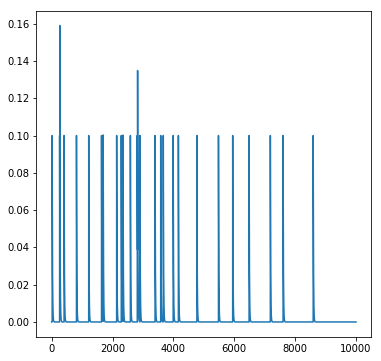

In [17]:
plt.figure(figsize=(6,6))
plt.plot(rewards)
plt.show()
plt.close()

In [18]:
sim.run(render=True, num_steps=num_steps)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


0.0

In [19]:
print(0,list(policy.predict(preprocess_state(0))[0]))
print(4,list(policy.predict(preprocess_state(4))[0]))
print(8,list(policy.predict(preprocess_state(8))[0]))
print(9,list(policy.predict(preprocess_state(9))[0]))
print(10,list(policy.predict(preprocess_state(10))[0]))
print(14,list(policy.predict(preprocess_state(14))[0]))
print(1,list(policy.predict(preprocess_state(1))[0]))

0 [0.0377335, 0.2642612, 0.034232248, 0.66377306]
4 [0.047361594, 0.2593816, 0.07771245, 0.6155444]
8 [0.027855644, 0.16176754, 0.044637598, 0.7657392]
9 [0.042556006, 0.21479535, 0.06267696, 0.6799717]
10 [0.032504328, 0.1803306, 0.07044574, 0.7167193]
14 [0.049184885, 0.26318353, 0.09864796, 0.5889836]
1 [0.03384358, 0.13177001, 0.04138316, 0.79300326]


In [20]:
print(0,list(value_function.predict(preprocess_state(0))[0]))
print(4,list(value_function.predict(preprocess_state(4))[0]))
print(8,list(value_function.predict(preprocess_state(8))[0]))
print(9,list(value_function.predict(preprocess_state(9))[0]))
print(10,list(value_function.predict(preprocess_state(10))[0]))
print(14,list(value_function.predict(preprocess_state(14))[0]))
print(1,list(value_function.predict(preprocess_state(1))[0]))

0 [2.142042e-06]
4 [8.6054206e-07]
8 [1.4901161e-08]
9 [2.5231391e-05]
10 [0.0038000718]
14 [-0.0046209805]
1 [-7.4505806e-08]


In [13]:
policy.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(16, 4) dtype=float32, numpy=
 array([[ 1.9311719e-01,  6.1105883e-01, -2.6848290e-02, -3.6378879e-02],
        [ 1.6769561e-01, -1.3033485e-01,  8.0286339e-03,  5.0215691e-01],
        [-4.9872026e-01, -1.4244895e-01,  4.6307382e-01, -4.0657473e-01],
        [-3.4942865e-01,  3.5576206e-01,  2.2551592e-01, -3.9138949e-01],
        [-1.9920322e-01, -1.7392020e-01, -5.8838654e-02, -4.8136029e-01],
        [-1.3097468e-01, -1.4414299e-01, -5.3456515e-01,  2.9970169e-02],
        [-3.6218131e-01, -2.4029669e-01,  2.2161229e-01,  4.9309069e-01],
        [ 4.9663794e-01, -4.5305347e-01, -4.1223282e-01, -6.7120671e-02],
        [-1.4895004e-01, -4.9044684e-02, -3.9275628e-02,  3.4282070e-01],
        [ 2.9059410e-01,  2.5294620e-01,  3.1439835e-01,  2.6725048e-01],
        [ 5.5106562e-02,  7.5367592e-02,  4.4883651e-01,  3.7357432e-01],
        [ 3.4298491e-01, -3.7068298e-01,  1.9303119e-01,  2.8492779e-01],
        [ 3.2209069e-01,  3.8724822e-01,  3.2

In [14]:
value_function.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(16, 1) dtype=float32, numpy=
 array([[-0.05076864],
        [-0.05090932],
        [-0.05114118],
        [-0.09524567],
        [-0.05112379],
        [ 0.43299246],
        [-0.0355727 ],
        [ 0.22713202],
        [-0.05104581],
        [-0.04896428],
        [-0.02971851],
        [ 0.03234208],
        [ 0.03557372],
        [-0.04800885],
        [-0.06271283],
        [ 0.1485455 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.05095926], dtype=float32)>]